In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

Solve the radiative transfer, the Schwarzschild, equation:
$$ dI_\nu = (-I_\nu + B_\nu(T)) n\sigma_\nu dz $$
This has the analytical solution:
$$ I_\nu(z) = I_\nu(z_0) e^{-\tau} + \int_{\tau_0}^\tau d\tau'\,e^{-(\tau-\tau')}\, B_\nu(\tau')$$
where $$\tau(z)\equiv \int_{z_0}^z dz' n\sigma_\nu(z') dz'$$

If we take a simple expression for absorbtion rate based on the density descrease, $n\sigma=\kappa e^{-z/H}$, then
$$ \tau(z) = \kappa H \left( 1- e^{-z/H}\right)$$

In [40]:
#Some constants and simple functions
hbar=1.0546e-34 #J -s
c=3.e8 #m/w
kb=1.38e-23 #J/K
h=2*3.14159*hbar
rsolar=6.955e8
lsolar=3.85e26
rorbit=1.5e11
rearth=6.37e6
km=1.e3
micron=1.e-6
lapse=6.5 #K/km
H = 8.5 #km
Tground=287
def bnu(nu,T):
    b=(2*np.pi*h*nu**3/c**2)/(np.exp(h*nu/(kb*T))-1.)
    return b
def bnuT(nu):
    return bnu(nu,T)
    

/var/folders/yt/44r1mdln1k7_0595qvt97vd00000gn/T/ipykernel_39453/155850986.py:16: RuntimeWarning: overflow encountered in exp
  b=(2*np.pi*h*nu**3/c**2)/(np.exp(h*nu/(kb*T))-1.)
/var/folders/yt/44r1mdln1k7_0595qvt97vd00000gn/T/ipykernel_39453/155850986.py:16: RuntimeWarning: overflow encountered in exp
  b=(2*np.pi*h*nu**3/c**2)/(np.exp(h*nu/(kb*T))-1.)


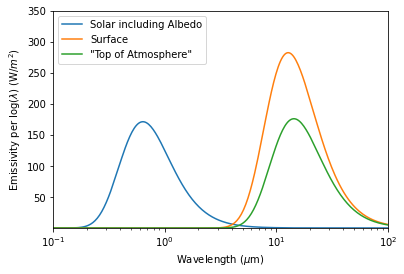

In [41]:
# To convert to W/m^2/log(wavelength), multiply by nu
nulog = np.arange(9.,16,.01)
nu=10.**nulog
wavel =c/nu
T=5750.
barr=bnu(nu,T) 
### multiply by flux reduction factor:
barr*=.7*(rsolar/rorbit)**2/4.
plt.plot(wavel*1.e6,barr*nu,label='Solar including Albedo')
T=287.
barr=bnu(nu,T) 
plt.plot(wavel*1.e6,barr*nu,label='Surface')
T=255.
barr=bnu(nu,T) # E-s/s^3  s^2/m^2 = W/m^2//Hz
plt.plot(wavel*1.e6,barr*nu,label='"Top of Atmosphere"')
plt.xscale('log')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Emissivity per log($\\lambda$) (W/$m^2$)')
#plt.yscale('log')
plt.axis([.1,100,1.e-3,350])
plt.legend()
plt.savefig('../Figures/toa.png')

In [42]:
#### Estimate flux when some of it is absorbed
T=5800.
numax=c/.3e-6 # wavelengths shorter than this are absorbed by high latitude atmosphere
actual,err=integrate.quad(bnuT,1.e12,numax)
full,err=integrate.quad(bnuT,1.e12,10*numax)
print(actual/full)


0.9676003019041769


In [43]:
def Temp(z):
    Temp=Tground-lapse*z
    if Temp < 220.: Temp=220.
    return Temp
def didz(y,z,updown):
    T=Temp(z)
    didz=updown*(-y+bnu(nu,T))*kappa*np.exp(-z/H) # updown=-1 if integrating downwards
    if z<0.: didz =0.
    return didz

In [44]:
## Upward flux
z0=.1
t=np.arange(z0,200.,.1) # 1 cm^{-1} = 1 (10^{-5} km)^{-1} = 10^5 km^{-1} in km
kappa=1. # per km
lapse=6.5 #K/km
wavel=15.*micron
nu=c/wavel
y0=bnu(nu,Temp(z0))
updown=1
inuup1=integrate.odeint(didz, y0, t,args=(updown,),rtol=1.e-11, atol=1.e-15)
y0=bnu(nu,Temp(z0))
kappa=.1 # per km
inuup2=integrate.odeint(didz, y0, t,args=(updown,),rtol=1.e-11, atol=1.e-15)
y0=bnu(nu,Temp(z0))
kappa=.01 # per km
inuup3=integrate.odeint(didz, y0, t,args=(updown,),rtol=1.e-11, atol=1.e-15)


0.013404935827204744 0.0009941406474216887 10.307692307692308


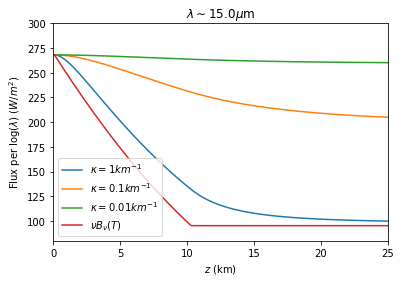

In [45]:
trop = (Tground-220)/lapse
T=np.zeros(np.size(t))
for i,z in enumerate(t):
    T[i]=Temp(z)
mu=kappa*H*(1.-np.exp(-t/H))
plt.plot(t,inuup1*nu,label='$\\kappa=1km^{-1}$')
plt.plot(t,inuup2*nu,label='$\\kappa=0.1km^{-1}$')
plt.plot(t,inuup3*nu,label='$\\kappa=0.01km^{-1}$')
plt.plot(t,bnu(nu,T)*nu,label='$\\nu B_\\nu(T)$')
plt.title('$\\lambda\sim$'+str(wavel/1.e-6)+'$\\mu$m')
plt.xlabel('$z$ (km)')
plt.legend()
plt.ylabel('Flux per log($\\lambda$) ($W/m^2$)')
trop = (Tground-220)/lapse#220=tground-lapse*z
#plt.plot([trop,trop],[1.e-3,1])
print(y0*1.e9,mu[0],trop)
plt.axis([0,25,80,300])
plt.savefig('../Figures/co2flux_cd.png')

In [46]:
kappa=.02 # co2 doubles
inuup3D=integrate.odeint(didz, y0, t,args=(updown,),rtol=1.e-11, atol=1.e-15)
kappa=2. # co2 doubles
inuup1D=integrate.odeint(didz, y0, t,args=(updown,),rtol=1.e-11, atol=1.e-15)
kappa=.2 # co2 doubles
inuup2D=integrate.odeint(didz, y0, t,args=(updown,),rtol=1.e-11, atol=1.e-15)


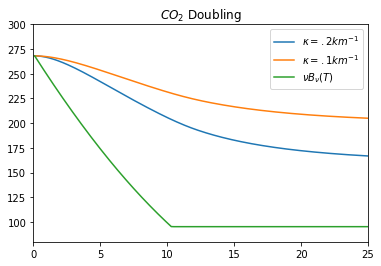

In [47]:
plt.plot(t,inuup2D*nu,label='$\\kappa=.2km^{-1}$')
plt.plot(t,inuup2*nu,label='$\\kappa=.1km^{-1}$')
plt.plot(t,bnu(nu,T)*nu,label='$\\nu B_\\nu(T)$')
plt.title('$CO_2$ Doubling')
plt.legend()
plt.axis([0,25,80,300])

plt.savefig('../Figures/co2doubling_cd_k.1.png')

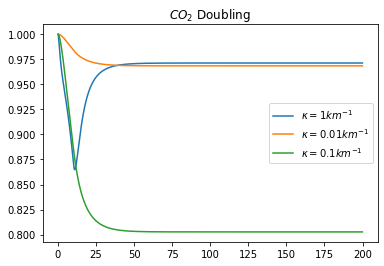

In [48]:
plt.plot(t,inuup1D/inuup1,label='$\\kappa=1km^{-1}$')
plt.plot(t,inuup3D/inuup3,label='$\\kappa=0.01km^{-1}$')
plt.plot(t,inuup2D/inuup2,label='$\\kappa=0.1km^{-1}$')
plt.title('$CO_2$ Doubling')
plt.legend()
plt.savefig('../Figures/co2doubling_cd.png')

## CO$_2$ Cross Sections

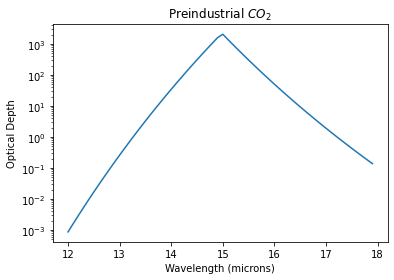

In [49]:
vib=667.5 # cm^{-1}
r=0.089 # cm
s0=3.71e-19*1.e-4 # m^2
micron=1.e4
n0=280.e-6*1.25/(30*1.67e-27) # m^{-3}
H=8.5
km=1.e3
def sigma(wavel):  #wavelength in microns, output in m^2
    k=micron/wavel
    sigma = s0*np.exp(-r*np.abs(k-vib))
    return sigma
def n(z):  # z in km, output in m^{-3}
    return n0*np.exp(-z/H)
wavel=np.arange(12.,18.,.1)
plt.plot(wavel,sigma(wavel)*n0*H*km)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Optical Depth')
plt.title('Preindustrial $CO_2$')
plt.yscale('log')
plt.savefig('../Figures/opticaldepth.png')

In [50]:
k=n0*sigma(wavel)*km
t=[0.,200]
final=[]
n=100
for i in range(np.size(k)):
    nu=c/(wavel[i]*1.e-6)
    y0=bnu(nu,287)
    #print(nu*y0)
    kappa=k[i]
    answer=integrate.odeint(didz, y0, t,args=(updown,),rtol=1.e-11, atol=1.e-15)
    final.append(nu*answer[1,0])

In [51]:
final2=[]
n=100
for i in range(np.size(k)):
    nu=c/(wavel[i]*1.e-6)
    y0=bnu(nu,287)
    #print(nu*y0)
    kappa=2*k[i]
    answer2=integrate.odeint(didz, y0, t,args=(updown,),rtol=1.e-11, atol=1.e-15)
    final2.append(nu*answer2[1,0])

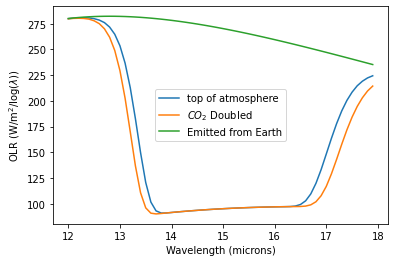

In [52]:
nuarray=c*1.e6/wavel
plt.plot(wavel,final,label='top of atmosphere')
plt.plot(wavel,final2,label='$CO_2$ Doubled')
plt.plot(wavel,nuarray*bnu(nuarray,287),label='Emitted from Earth')
plt.xlabel('Wavelength (microns)')
plt.ylabel('OLR (W/m$^2$/log($\lambda$))')
plt.legend()
plt.savefig('../Figures/olr.png')

In [53]:
# Integrate!
olr = 0.1*np.sum(final/wavel) ## 0.1 microns is binning, so
# \int d\lambda B_\lambda = \sum_i \Delta\lambda B_\lambda = 0.1 microns * \sum_ final_i/wavel_i
#print(olr)
olr2 = 0.1*np.sum(final2/wavel) ## 0.1 microns is binning, so
print(olr2,olr,'W/m$^2$')
print('Change in OLR when co2 doubles from pre-industrial:')
print(olr2-olr,'W/m$^2$')

60.37138066079088 64.15079586828543 W/m$^2$
Change in OLR when co2 doubles from pre-industrial:
-3.7794152074945515 W/m$^2$


In [54]:
## See how things change as the abundance changes
abundance=np.arange(1.,2.01,.1)
olrarr=[]
for abun in abundance:
    olr=[]
    for i in range(np.size(k)):
        nu=c/(wavel[i]*1.e-6)
        y0=bnu(nu,287)
        kappa=abun*k[i]
        answer_abun=integrate.odeint(didz, y0, t,args=(updown,),rtol=1.e-11, atol=1.e-15)
        olr.append(nu*answer_abun[1,0])
    olrint=0.1*np.sum(olr/wavel)
    olrarr.append(olrint)


(11,)


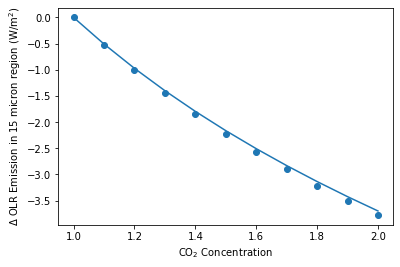

In [55]:
print(np.shape(olrarr))
plt.scatter(abundance,olrarr-olrarr[0])
abundance=np.array(abundance)
plt.plot(abundance,-3.7*np.log2(abundance/abundance[0]))
plt.xlabel('CO$_2$ Concentration')
plt.ylabel('$\Delta$ OLR Emission in 15 micron region (W/m$^2$)')
plt.savefig('../Figures/olrlog.png')

Text(0, 0.5, '$CO_2$ (GigaTons Carbon)')

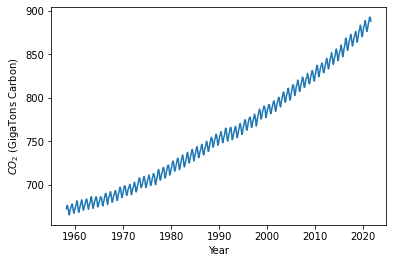

In [63]:
filename='../Data/co2_mm_mlo.txt'
month=np.loadtxt(filename).T[2]
co2=np.loadtxt(filename).T[3]
gtc=2.13 # global tons of carbon for 1 ppm
plt.plot(month,co2*gtc)
plt.xlabel('Year')
plt.ylabel('$CO_2$ (GigaTons Carbon)')

Text(0, 0.5, 'Global Carbon Emissions (GTons)')

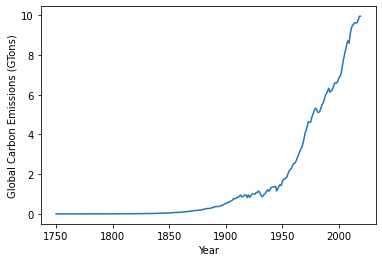

In [59]:
import pandas as pd
co2=pd.read_csv('../Data/owid-co2-data.csv')
world=co2[co2['country']=='World']
year=world['year']
emit=world['co2']
plt.plot(year,emit/3.664/1.e3) # divide by 1.e3 because it is millions not billons
# the 3.664 is the number of nuclei in CO_2 [12+32=44] divided by that in carbon [12]
plt.xlabel('Year')
plt.ylabel('Global Carbon Emissions (GTons)')

Text(0, 0.5, 'Cumulative Anthropogenic Carbon Emissions (Gtons)')

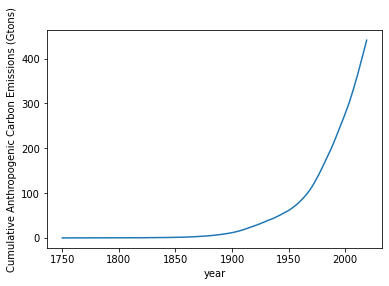

In [60]:
n=np.size(emit)
cum=np.zeros(n)
for i in range(n):
    cum[i]=np.sum(emit[:i])
plt.plot(year,cum/3.664/1.e3)
plt.xlabel('year')
plt.ylabel('Cumulative Anthropogenic Carbon Emissions (Gtons)')

In [62]:
print(np.size(day)/62.)

12.274193548387096


Text(0, 0.5, '$CO_2$ (GigaTons Carbon)')

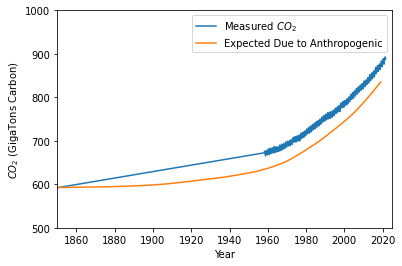

In [84]:
co2_a=np.insert(co2,0,278)
month_a=np.insert(month,0,1850)
plt.plot(month_a,co2_a*gtc,label="Measured $CO_2$")

pre_industrial=278*gtc ## pre-industrial value was 278 parts per million
atmosphere_remain=.55
predicted= pre_industrial + atmosphere_remain*cum/3.664/1.e3
plt.plot(year,predicted,label='Expected Due to Anthropogenic')
plt.axis([1850,2025,500,1000])
plt.legend()
plt.xlabel('Year')
plt.ylabel('$CO_2$ (GigaTons Carbon)')

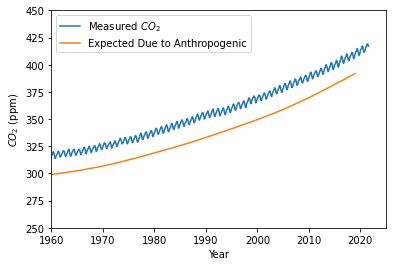

In [90]:
### ppm
plt.plot(month_a,co2_a,label="Measured $CO_2$")

pre_industrial=278 ## pre-industrial value was 278 parts per million
atmosphere_remain=.55
predicted= pre_industrial + atmosphere_remain*cum/3.664/1.e3/gtc
plt.plot(year,predicted,label='Expected Due to Anthropogenic')
plt.axis([1960,2025,250,450])
plt.legend()
plt.xlabel('Year')
plt.ylabel('$CO_2$ (ppm)')
plt.savefig('../Figures/co2ppm.png')

In [88]:
print(predicted[-1])

391.91939962738587
